# Rheological Parameter Exploration
Using TidalPy's high-level functional programming, we will see how different rheological parameters affect tidal dissipation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
from matplotlib.gridspec import GridSpec
from cmcrameri import cm as cmc
import ipywidgets as widgets
from ipywidgets import interact, IntSlider, FloatSlider
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf')

from TidalPy.constants import mass_solar, radius_solar, luminosity_solar, mass_earth, radius_earth, au, G
from TidalPy.toolbox import quick_tidal_dissipation
from TidalPy.utilities.conversions import days2rads
from TidalPy.utilities.numpy_helper.array_other import neg_array_for_log_plot
from TidalPy.stellar import equilibrium_insolation_williams

plt.rcParams['figure.figsize'] = [9.5 * .75, 6 * .75]
plt.rcParams.update({'font.size': 14})
%matplotlib notebook

C:\Users\joepr\AppData\Local\Temp\ipykernel_10008\4264696300.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf')


### Planetary Properties
We will use planetary properties approximately based on the exoplanet: TRAPPIST 1e

In [2]:
# TRAPPIST-1 (the star) Parameters [Stassun+2019, Gillon+2017]
star_lumonsity = 10**(-3.28) * luminosity_solar
star_radius = 0.1148270 * radius_solar
star_mass = 0.09077820 * mass_solar

# TRAPPIST-1e Parameters [Agol+2021, Grimm+2018]
planet_radius = 0.920 * radius_earth
planet_mass = 0.692 * mass_earth
planet_semi_major_axis = 0.02925 * au
planet_orbital_period = 6.101013
planet_orbital_frequency = days2rads(planet_orbital_period)
planet_eccentricity = 0.00510
planet_obliquity = np.radians(90. - 89.793)

# # Sun
# star_lumonsity = luminosity_solar
# star_radius = radius_solar
# star_mass = mass_solar

# # Mercury Parameters
# planet_radius = 0.3829 * radius_earth
# planet_mass = 0.0553 * mass_earth
# planet_semi_major_axis = 0.38709893 * au
# planet_orbital_period = 87.96926
# planet_orbital_frequency = days2rads(planet_orbital_period)
# planet_eccentricity = 0.20563069
# planet_obliquity = np.radians(0.0329)  # [Genova+2019]


planet_moi = (2. / 5.) * planet_mass * planet_radius**2
# We will assume that only 50% of the world's volume is participating in tidal dissipation
tidal_scale = 0.5
# Calculate other properties
planet_density = planet_mass / ((4. / 3.) * np.pi * planet_radius**3)
planet_gravity = G * planet_mass / (planet_radius**2)

# Conversions
sec2_2_yr2 = (3.154e7)**2

## Viscosity Domain
Here we calculate tidal heating versus insolation temperature in over a domain of mantle viscosity

<IPython.core.display.Javascript object>


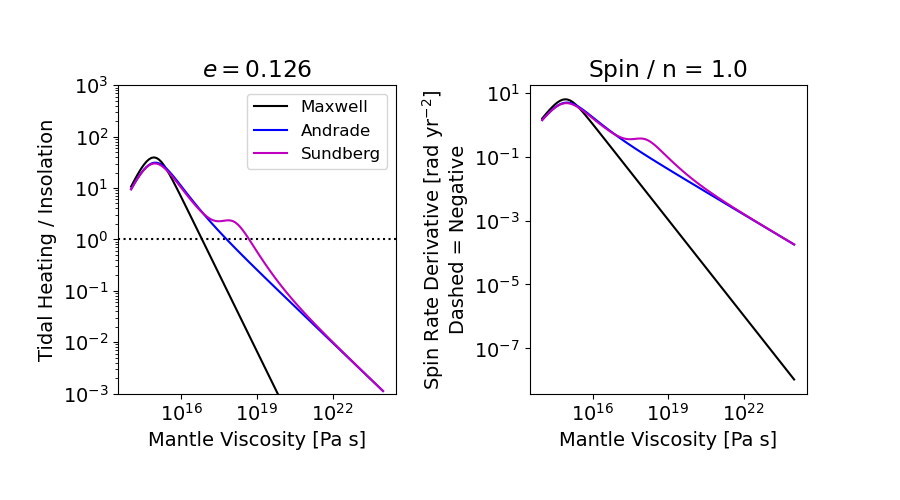

interactive(children=(FloatSlider(value=0.2, description='$\\delta{}J$', max=1.0, min=0.01, step=0.05), FloatS…

In [3]:
# Setup domain
viscosity_domain = np.logspace(14., 24., 100)
shear_domain = 50.e9 * np.ones_like(viscosity_domain)

# Setup figure
fig_sync, axes_sync = plt.subplots(ncols=2, nrows=1, figsize=(9, 5))
fig_sync.tight_layout(pad=4.0)
ax_sync_heating = axes_sync[0]
ax_sync_torque = axes_sync[1]
ax_sync_heating.set(xlabel='Mantle Viscosity [Pa s]', ylabel='Tidal Heating / Insolation', yscale='log',
                    xscale='log', ylim=(1e-3, 1e3))
ax_sync_torque.set(xlabel='Mantle Viscosity [Pa s]', ylabel='Spin Rate Derivative [rad yr$^{-2}$]\nDashed = Negative',
                   yscale='log', xscale='log')

# Plot lines
ax_sync_heating.axhline(y=1e0, color='k', ls=':')
rheo_lines_heating = [ax_sync_heating.plot(viscosity_domain, viscosity_domain, 'k', label='Maxwell')[0],
                      ax_sync_heating.plot(viscosity_domain, viscosity_domain, 'b', label='Andrade')[0],
                      ax_sync_heating.plot(viscosity_domain, viscosity_domain, 'm', label='Sundberg')[0]]
rheo_lines_torque = [ax_sync_torque.plot(viscosity_domain, viscosity_domain, 'k', label='Maxwell')[0],
                     ax_sync_torque.plot(viscosity_domain, viscosity_domain, 'b', label='Andrade')[0],
                     ax_sync_torque.plot(viscosity_domain, viscosity_domain, 'm', label='Sundberg-Cooper')[0]]
rheo_lines_torque_neg = [ax_sync_torque.plot(viscosity_domain, viscosity_domain, '--k', label='Maxwell')[0],
                         ax_sync_torque.plot(viscosity_domain, viscosity_domain, '--b', label='Andrade')[0],
                         ax_sync_torque.plot(viscosity_domain, viscosity_domain, '--m', label='Sundberg')[0]]
plt.show()

def sync_rotation(voigt_compliance_offset=.2,
                  voigt_viscosity_offset=.02,
                  alpha=.333,
                  zeta_power=0.,
                  critical_period=100.,
                  albedo=0.3,
                  eccentricity_pow=np.log10(planet_eccentricity),
                  obliquity_deg=0.,
                  force_spin_sync=True,
                  spin_orbit_ratio=1.,
                  eccentricity_truncation_lvl=2,
                  max_tidal_order_l=2):
    
    eccentricity = 10.**eccentricity_pow
    zeta = 10.**(zeta_power)
    obliquity = np.radians(obliquity_deg)
    critical_freq = 2. * np.pi / (86400. * critical_period)
    dissipation_data = dict()
    rheology_data = {
        'maxwell': (rheo_lines_heating[0], rheo_lines_torque[0], rheo_lines_torque_neg[0],
                    tuple()),
        'andrade': (rheo_lines_heating[1], rheo_lines_torque[1], rheo_lines_torque_neg[1],
                    (alpha, zeta)),
        'sundberg': (rheo_lines_heating[2], rheo_lines_torque[2], rheo_lines_torque_neg[2],
                     (voigt_compliance_offset, voigt_viscosity_offset, alpha, zeta)),
    }
    
    if force_spin_sync:
        spin_period = None
    else:
        # The ratio is in the denominator since it is a frequency ratio.
        spin_period = planet_orbital_period / spin_orbit_ratio
        
    # Calculate insolation based on distance and eccentricity
    insolation = \
        equilibrium_insolation_williams(star_lumonsity, planet_semi_major_axis, albedo, planet_radius, eccentricity)
    
    for rheo_name, (heating_line, torque_line, torque_neg_line, rheo_input) in rheology_data.items():
        # Perform main tidal calculation
        dissipation_data[rheo_name] = \
            quick_tidal_dissipation(star_mass, planet_radius, planet_mass, planet_gravity, planet_density, planet_moi,
                                    viscosity=viscosity_domain, shear_modulus=shear_domain, rheology=rheo_name,
                                    complex_compliance_inputs=rheo_input, eccentricity=eccentricity, obliquity=obliquity,
                                    orbital_period=planet_orbital_period, spin_period=spin_period,
                                    max_tidal_order_l=max_tidal_order_l,
                                    eccentricity_truncation_lvl=eccentricity_truncation_lvl)
        
        spin_derivative = dissipation_data[rheo_name]['dUdO'] * (star_mass / planet_moi)
        heating_line.set_ydata(dissipation_data[rheo_name]['tidal_heating'] / insolation)
        # Convert spin_derivative from rad s-2 to hour per year
        spin_derivative = sec2_2_yr2 * spin_derivative
        spin_derivative_pos = np.copy(spin_derivative)
        spin_derivative_pos[spin_derivative_pos<=0.] = np.nan
        spin_derivative_neg = np.copy(spin_derivative)
        spin_derivative_neg[spin_derivative_neg>0.] = np.nan
    
        torque_line.set_ydata(np.abs(spin_derivative_pos))
        torque_neg_line.set_ydata(np.abs(spin_derivative_neg))
        
    
    ax_sync_heating.legend(loc='upper right', fontsize=12)
    ax_sync_heating.relim()
    ax_sync_heating.autoscale_view()
    ax_sync_heating.set_title('$e = ' + f'{eccentricity:0.3f}' +'$')
    ax_sync_torque.relim()
    ax_sync_torque.autoscale_view()
    ax_sync_torque.set_title('Spin / n = ' + f'${spin_orbit_ratio:0.1f}$')
    fig_sync.canvas.draw_idle()

run_interactive_sync = interact(
    sync_rotation,
    voigt_compliance_offset=FloatSlider(value=0.2, min=0.01, max=1., step=0.05, description='$\\delta{}J$'),
    voigt_viscosity_offset=FloatSlider(value=0.02, min=0.01, max=0.1, step=0.01, description='$\\delta{}\\eta$'),
    alpha=FloatSlider(value=0.33, min=0.05, max=0.8, step=0.02, description='$\\alpha_{\\text{And}}$'),
    zeta_power=FloatSlider(value=0., min=-5., max=5., step=0.5, description='$\\zeta_{\\text{And}}^{X}$'),
    critical_period=FloatSlider(value=100., min=30., max=150., step=10, description='$P_{crit}$'),
    albedo=FloatSlider(value=0.3, min=0.1, max=0.9, step=0.1, description='Albedo'),
    eccentricity_pow=FloatSlider(value=-0.522879, min=-4, max=-0.09, step=0.05, description='$e^{X}$'),
    obliquity_deg=FloatSlider(value=0, min=0., max=90., step=1., description='Obliquity'),
    force_spin_sync=False,
    spin_orbit_ratio=FloatSlider(value=1., min=0.5, max=9., step=.1, description='$\\dot{\\theta} / n$'),
    eccentricity_truncation_lvl=IntSlider(value=8, min=2, max=20, step=2, description='$e$ Truncation'),
    max_tidal_order_l=IntSlider(value=2, min=2, max=3, step=1, description='Max Order $l$')
)

## Frequency Domain

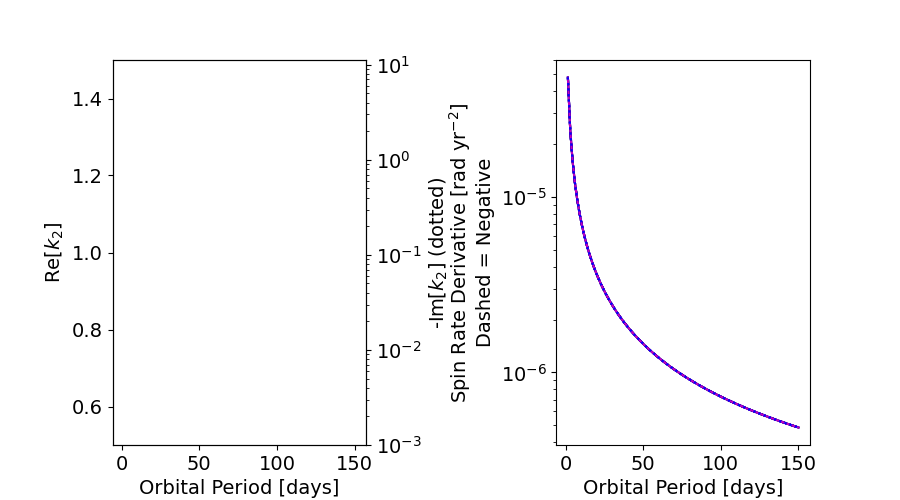

interactive(children=(FloatSlider(value=0.2, description='$\\delta{}J$', max=1.0, min=0.01, step=0.05), FloatS…

In [4]:
# Setup domain
period_domain = np.linspace(0., 150., 100)
freqeuncy_domain = days2rads(period_domain)

# Setup figure
fig_freq, axes_freq = plt.subplots(ncols=2, nrows=1, figsize=(9, 5))
# fig_freq.tight_layout()
plt.subplots_adjust(wspace=0.75)

ax_freq_love_real = axes_freq[0]
ax_freq_love_imag = ax_freq_love_real.twinx()
ax_freq_torque = axes_freq[1]
ax_freq_love_real.set(xlabel='Orbital Period [days]', ylabel='Re[$k_{2}$]', yscale='linear',
                    xscale='linear', ylim=(0.5, 1.5))
ax_freq_love_imag.set(xlabel='Orbital Period [days]', ylabel='-Im[$k_{2}$] (dotted)', yscale='log',
                    xscale='linear', ylim=(1e-3, 0))
ax_freq_torque.set(xlabel='Orbital Period [days]', ylabel='Spin Rate Derivative [rad yr$^{-2}$]\nDashed = Negative',
                   yscale='log', xscale='linear')

# Plot lines
rheo_lines_love_real = [ax_freq_love_real.plot(period_domain, freqeuncy_domain, 'k', label='Maxwell')[0],
                        ax_freq_love_real.plot(period_domain, freqeuncy_domain, 'b', label='Andrade')[0],
                        ax_freq_love_real.plot(period_domain, freqeuncy_domain, 'm', label='Sundberg')[0],
                        ax_freq_love_real.plot(period_domain, freqeuncy_domain, '--b', label='Andrade ($\\omega$)')[0]]
rheo_lines_love_imag = [ax_freq_love_imag.plot(period_domain, freqeuncy_domain, 'k', label='Maxwell', ls=':')[0],
                        ax_freq_love_imag.plot(period_domain, freqeuncy_domain, 'b', label='Andrade', ls=':')[0],
                        ax_freq_love_imag.plot(period_domain, freqeuncy_domain, 'm', label='Sundberg', ls=':')[0],
                        ax_freq_love_imag.plot(period_domain, freqeuncy_domain, '--b', label='Andrade ($\\omega$)', ls=':')[0]]
rheo_lines_torque = [ax_freq_torque.plot(period_domain, freqeuncy_domain, 'k', label='Maxwell')[0],
                     ax_freq_torque.plot(period_domain, freqeuncy_domain, 'b', label='Andrade')[0],
                     ax_freq_torque.plot(period_domain, freqeuncy_domain, 'm', label='Sundberg-Cooper')[0],
                     ax_freq_torque.plot(period_domain, freqeuncy_domain, '--b', label='Andrade ($\\omega$)')[0]]
rheo_lines_torque_neg = [ax_freq_torque.plot(period_domain, freqeuncy_domain, '--k', label='Maxwell')[0],
                         ax_freq_torque.plot(period_domain, freqeuncy_domain, '--b', label='Andrade')[0],
                         ax_freq_torque.plot(period_domain, freqeuncy_domain, '--m', label='Sundberg')[0],
                         ax_freq_torque.plot(period_domain, freqeuncy_domain, ':b', label='Andrade ($\\omega$)')[0]]
plt.show()

def love_number_calc(voigt_compliance_offset=.2,
                     voigt_viscosity_offset=.02,
                     alpha=.333,
                     zeta_power=0.,
                     critical_period=100.,
                     viscosity_power=18.,
                     shear_power=10.,
                     eccentricity_pow=np.log10(planet_eccentricity),
                     obliquity_deg=0.,
                     force_spin_sync=True,
                     spin_period=20.,
                     eccentricity_truncation_lvl=2,
                     max_tidal_order_l=2):
    
    eccentricity = 10.**eccentricity_pow
    zeta = 10.**(zeta_power)
    obliquity = np.radians(obliquity_deg)
    dissipation_data = dict()
    critical_freq = 2. * np.pi / (86400. * critical_period)
    rheology_data = {
        'maxwell': (rheo_lines_love_real[0], rheo_lines_love_imag[0], rheo_lines_torque[0], rheo_lines_torque_neg[0],
                    tuple()),
        'andrade': (rheo_lines_love_real[1], rheo_lines_love_imag[1], rheo_lines_torque[1], rheo_lines_torque_neg[1],
                    (alpha, zeta)),
        'sundberg': (rheo_lines_love_real[2], rheo_lines_love_imag[2], rheo_lines_torque[2], rheo_lines_torque_neg[2],
                     (voigt_compliance_offset, voigt_viscosity_offset, alpha, zeta)),
        'andrade_freq': (rheo_lines_love_real[3], rheo_lines_love_imag[3], rheo_lines_torque[3], rheo_lines_torque_neg[3],
                    (alpha, zeta, critical_freq))
    }
    
    if force_spin_sync:
        spin_period = None
    else:
        # The ratio is in the denominator since it is a frequency ratio.
        spin_period = spin_period
    
    for rheo_name, (love_real_line, love_imag_line, torque_line, torque_neg_line, rheo_input) in rheology_data.items():
        # Perform main tidal calculation
        dissipation_data[rheo_name] = \
            quick_tidal_dissipation(star_mass, planet_radius, planet_mass, planet_gravity, planet_density, planet_moi,
                                    viscosity=10**viscosity_power, shear_modulus=10**shear_power, rheology=rheo_name,
                                    complex_compliance_inputs=rheo_input, eccentricity=eccentricity, obliquity=obliquity,
                                    orbital_period=period_domain, spin_period=spin_period,
                                    max_tidal_order_l=max_tidal_order_l,
                                    eccentricity_truncation_lvl=eccentricity_truncation_lvl)
        
        love_real_line.set_ydata(np.real(dissipation_data[rheo_name]['love_number_by_orderl'][2]))
        love_imag_line.set_ydata(-np.imag(dissipation_data[rheo_name]['love_number_by_orderl'][2]))
        
        spin_derivative = dissipation_data[rheo_name]['dUdO'] * (star_mass / planet_moi)
        # Convert spin_derivative from rad s-2 to hour per year
        spin_derivative = sec2_2_yr2 * spin_derivative
        spin_derivative_pos = np.copy(spin_derivative)
        spin_derivative_pos[spin_derivative_pos<=0.] = np.nan
        spin_derivative_neg = np.copy(spin_derivative)
        spin_derivative_neg[spin_derivative_neg>0.] = np.nan
    
        torque_line.set_ydata(np.abs(spin_derivative_pos))
        torque_neg_line.set_ydata(np.abs(spin_derivative_neg))
        
    if spin_period is not None:
        ax_freq_love_real.axvline(x=spin_period, ls=':', c='green')
        ax_freq_love_real.axvline(x=89., ls=':', c='k')
    ax_freq_love_real.legend(loc='lower right', fontsize=12)
    ax_freq_love_real.relim()
    ax_freq_love_real.autoscale_view()
    ax_freq_love_real.set_title('$e = ' + f'{eccentricity:0.3f}' +'$')
    ax_freq_love_imag.relim()
    ax_freq_love_imag.autoscale_view()
    ax_freq_love_imag.set_title('$e = ' + f'{eccentricity:0.3f}' +'$')
    ax_freq_torque.relim()
    ax_freq_torque.autoscale_view()
    fig_freq.canvas.draw_idle()

run_interactive_love = interact(
    love_number_calc,
    voigt_compliance_offset=FloatSlider(value=0.2, min=0.01, max=1., step=0.05, description='$\\delta{}J$'),
    voigt_viscosity_offset=FloatSlider(value=0.02, min=0.01, max=0.1, step=0.01, description='$\\delta{}\\eta$'),
    alpha=FloatSlider(value=0.33, min=0.05, max=0.8, step=0.02, description='$\\alpha_{\\text{And}}$'),
    zeta_power=FloatSlider(value=0., min=-5., max=5., step=0.5, description='$\\zeta_{\\text{And}}^{X}$'),
    critical_period=FloatSlider(value=100., min=30., max=150., step=10, description='$P_{crit}$'),
    viscosity_power=FloatSlider(value=17., min=14, max=28, step=1.0, description='$\\eta^{X}$'),
    shear_power=FloatSlider(value=10., min=7., max=11., step=0.5, description='$\\mu^{X}$'),
    eccentricity_pow=FloatSlider(value=np.log10(0.2), min=np.log10(0.001), max=np.log10(0.8), step=0.05,
                                 description='$e^{X}$'),
    obliquity_deg=FloatSlider(value=0, min=0., max=90., step=1., description='Obliquity'),
    force_spin_sync=True,
    spin_period=FloatSlider(value=59., min=1.0, max=200., step=2., description='$P_{s}$'),
    eccentricity_truncation_lvl=IntSlider(value=8, min=2, max=20, step=2, description='$e$ Truncation'),
    max_tidal_order_l=IntSlider(value=2, min=2, max=3, step=1, description='Max Order $l$')
)

## Resonance Trapping
Here we look at how material properties change how a planet can become trapped at a higher-order spin-orbit resonance

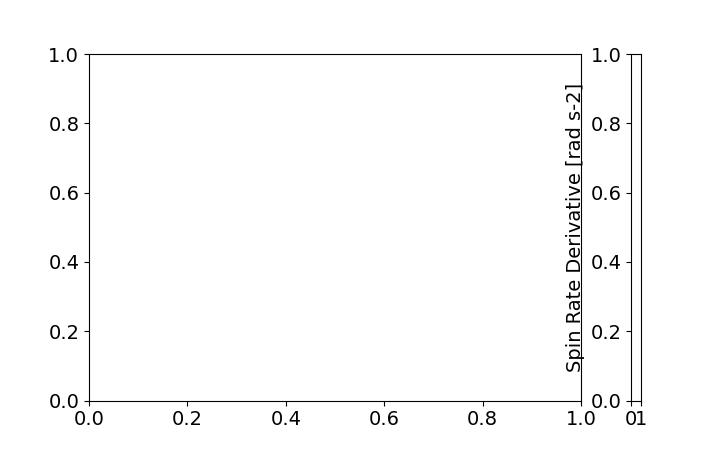

interactive(children=(IntSlider(value=3, description='Cbar Scale', max=6), FloatSlider(value=0.2, description=…

In [5]:
# Setup scales
scale_info_list = [
((86400.)**2 * (360. / (2. * np.pi)), '[deg day$^{-2}$]'),
((2.628e+6)**2 * (360. / (2. * np.pi)), '[deg month$^{-2}$]'),
((3.154e7/2)**2 * (360. / (2. * np.pi)), '[deg semi-yr$^{-2}$]'),
((3.154e7)**2 * (360. / (2. * np.pi)), '[deg yr$^{-2}$]'),
((3.154e7 * 10)**2 * (360. / (2. * np.pi)),'[deg dayr$^{-2}$]'),
((3.154e7 * 100)**2 * (360. / (2. * np.pi)), '[deg hyr$^{-2}$]'),
((3.154e7 * 1000)**2 * (360. / (2. * np.pi)), '[deg kyr$^{-2}$]')
]

cpoints = np.linspace(-3, 3, 45)
zticks = [-3, -2, -1, 0, 1, 2, 3]
zlabels = ['$-10^{3}$', '$-10^{2}$', '$-10^{1}$',
           '$\\;\\;\\;10^{0}$', '$\\;\\;\\;10^{1}$', '$\\;\\;\\;10^{2}$', '$\\;\\;\\;10^{3}$']

# Setup domain
x = eccentricity_domain = np.logspace(-2., 0., 80)
y = spin_ratio_domain = np.linspace(0.5, 6., 70)
eccen_mtx, spin_ratio_mtx = np.meshgrid(eccentricity_domain, spin_ratio_domain)
shape = eccen_mtx.shape
eccen_mtx = eccen_mtx.flatten()
spin_ratio_mtx = spin_ratio_mtx.flatten()
spin_frequency = spin_ratio_mtx * planet_orbital_frequency

# Setup figure
fig_trap = plt.figure()
gs = GridSpec(1, 2, figure=fig_trap, wspace=None, hspace=None, width_ratios=[.98, .02])
ax_trap = fig_trap.add_subplot(gs[0, 0])
ax_cb = fig_trap.add_subplot(gs[0, 1])
fig_sync.tight_layout()
ax_cb.set(ylabel='Spin Rate Derivative [rad s-2]')

plt.show()

def sync_rotation(cbar_scale_set=2,
                  voigt_compliance_offset=.2,
                  voigt_viscosity_offset=.02,
                  alpha=.333,
                  zeta_power=0.,
                  viscosity_power=22.,
                  shear_power=10.69897,
                  obliquity_deg=0.,
                  eccentricity_truncation_lvl=2,
                  max_tidal_order_l=2):
    
    viscosity = 10.**viscosity_power
    shear = 10.**shear_power
    zeta = 10.**zeta_power
    obliquity = np.radians(obliquity_deg)
    rheo_input = (voigt_compliance_offset, voigt_viscosity_offset, alpha, zeta)
    
    if max_tidal_order_l > 2 and eccentricity_truncation_lvl == 22:
        raise NotImplemented
    
    dissipation_data = \
        quick_tidal_dissipation(star_mass, planet_radius, planet_mass, planet_gravity, planet_density, planet_moi,
                                viscosity=viscosity, shear_modulus=shear, rheology='sundberg',
                                complex_compliance_inputs=rheo_input, eccentricity=eccen_mtx, obliquity=obliquity,
                                orbital_frequency=planet_orbital_frequency, spin_frequency=spin_frequency,
                                max_tidal_order_l=max_tidal_order_l,
                                eccentricity_truncation_lvl=eccentricity_truncation_lvl)
        
    spin_derivative = dissipation_data['dUdO'] * (star_mass / planet_moi)
            
    scale, unit_label = scale_info_list[cbar_scale_set]
    
    spin_derivative *= scale
    dspin_dt_targ_pos, dspin_dt_targ_neg = neg_array_for_log_plot(spin_derivative)
    
    # Make data Symmetric Log (for negative logscale plotting)
    logpos = np.log10(dspin_dt_targ_pos)
    logpos[logpos < 0.] = 0.
    negative_index = ~np.isnan(dspin_dt_targ_neg)
    logneg = np.log10(dspin_dt_targ_neg[negative_index])
    logneg[logneg < 0.] = 0.
    dspin_dt_targ_combo = logpos
    dspin_dt_targ_combo[negative_index] = -logneg
    dspin_dt_targ_combo = dspin_dt_targ_combo.reshape(shape)

    ax_trap.clear()
    cb_data = ax_trap.contourf(x, y, dspin_dt_targ_combo, cpoints, cmap=cmc.vik)
    
    ax_cb.clear()
    cb = plt.colorbar(cb_data, cax=ax_cb, ticks=zticks)
    
    ax_trap.set(xlabel='Eccentricity', ylabel='Spin Rate / Orbital Motion', yscale='linear',
                xscale='log')
    cb.set_label('Spin Rate Derivative ' + unit_label)
    cb.ax.set_yticklabels(zlabels)
    fig_trap.canvas.draw_idle()
    plt.tight_layout()

run_interactive_sync = interact(
    sync_rotation,
    cbar_scale_set = IntSlider(value=3, min=0, max=6, step=1, description='Cbar Scale'),
    voigt_compliance_offset=FloatSlider(value=0.2, min=0.01, max=1., step=0.05, description='$\\delta{}J$'),
    voigt_viscosity_offset=FloatSlider(value=0.02, min=0.01, max=0.1, step=0.01, description='$\\delta{}\\eta$'),
    alpha=FloatSlider(value=0.333, min=0.05, max=0.8, step=0.02, description='$\\alpha_{\\text{And}}$'),
    zeta_power=FloatSlider(value=0., min=-5., max=5., step=0.5, description='$\\zeta_{\\text{And}}^{X}$'),
    viscosity_power=FloatSlider(value=22., min=14, max=28, step=1.0, description='$\\eta^{X}$'),
    shear_power=FloatSlider(value=10.69897, min=7., max=11., step=0.5, description='$\\mu^{X}$'),
    obliquity_deg=FloatSlider(value=0, min=0., max=90., step=1., description='Obliquity'),
    eccentricity_truncation_lvl=IntSlider(value=4, min=2, max=20, step=2, description='$e$ Truncation'),
    max_tidal_order_l=IntSlider(value=2, min=2, max=3, step=1, description='Max $l$')
)